In [1]:
# ======================
# Block 1: Imports & Setup
# ======================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ======================
# Paths & Parameters
# ======================
train_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train"
test_path  = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test"

img_size   = 224
batch_size = 32
epochs     = 10

# ======================
# Transforms
# ======================
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # ✅ RGB normalize
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # ✅ RGB normalize
])

# ======================
# Datasets
# ======================
train_valid_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset        = datasets.ImageFolder(root=test_path,  transform=val_test_transforms)

# Split train_valid into train/val
train_size = int(0.9 * len(train_valid_dataset))
val_size   = len(train_valid_dataset) - train_size
train_data, val_data = random_split(train_valid_dataset, [train_size, val_size])

# Apply val transforms
val_data.dataset.transform = val_test_transforms

# ======================
# Dataloaders
# ======================
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ======================
# Class names
# ======================
class_names = train_valid_dataset.classes

print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_dataset)}")
print("Classes:", class_names)


Using device: cuda
Train samples: 8644 | Val samples: 961 | Test samples: 1000
Classes: ['benign', 'malignant']


In [2]:
# ======================
# Block 2: Dataset & Dataloaders
# ======================

from torchvision import datasets

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # ✅ RGB normalize
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # ✅ RGB normalize
])

# Datasets (ImageFolder instead of MultiBoneDataset)
train_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train"
test_path  = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test"

train_valid_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset        = datasets.ImageFolder(root=test_path,  transform=val_test_transforms)

# Split train_valid into train/val
train_size = int(0.9 * len(train_valid_dataset))
val_size   = len(train_valid_dataset) - train_size
train_data, val_data = random_split(train_valid_dataset, [train_size, val_size])

# Apply val transforms
val_data.dataset.transform = val_test_transforms

# Dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = train_valid_dataset.classes

# Print dataset info
print(f"Dataset sizes -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_dataset)}")
print("Classes:", class_names)


Dataset sizes -> Train: 8644, Val: 961, Test: 1000
Classes: ['benign', 'malignant']


In [3]:
# ======================
# Block 3: Model Setup with Fine-Tuning (VGG16)
# ======================
num_classes = len(class_names)
model_name = "VGG16"

# Load VGG16 with pretrained weights
model = models.vgg16(weights=None)

# Replace classifier
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 30% of parameters for fine-tuning
params = list(model.parameters())
unfreeze_layers = int(0.3 * len(params))
for param in params[-unfreeze_layers:]:
    param.requires_grad = True

# Move to device
model = model.to(device)

# Loss & Optimizer (only trainable params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

print(f"{model_name} ready with {num_classes} output classes (fine-tuning last 30%).")


VGG16 ready with 2 output classes (fine-tuning last 30%).


In [4]:
# ======================
# Block 4: Training Loop
# ======================
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Run training
history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device)


Epoch 1/10


Train Loss: 0.3650, Train Acc: 0.8325 | Val Loss: 0.2587, Val Acc: 0.8928

Epoch 2/10


Train Loss: 0.2693, Train Acc: 0.8862 | Val Loss: 0.2494, Val Acc: 0.8959

Epoch 3/10


Train Loss: 0.2442, Train Acc: 0.8982 | Val Loss: 0.2288, Val Acc: 0.9074

Epoch 4/10


Train Loss: 0.2344, Train Acc: 0.9009 | Val Loss: 0.2169, Val Acc: 0.9136

Epoch 5/10


Train Loss: 0.2119, Train Acc: 0.9138 | Val Loss: 0.2447, Val Acc: 0.8928

Epoch 6/10


Train Loss: 0.1993, Train Acc: 0.9193 | Val Loss: 0.2396, Val Acc: 0.9001

Epoch 7/10


Train Loss: 0.1858, Train Acc: 0.9255 | Val Loss: 0.2727, Val Acc: 0.8887

Epoch 8/10


Train Loss: 0.1824, Train Acc: 0.9276 | Val Loss: 0.2152, Val Acc: 0.9157

Epoch 9/10


Train Loss: 0.1727, Train Acc: 0.9331 | Val Loss: 0.2222, Val Acc: 0.9147

Epoch 10/10


Train Loss: 0.1642, Train Acc: 0.9363 | Val Loss: 0.2753, Val Acc: 0.8970


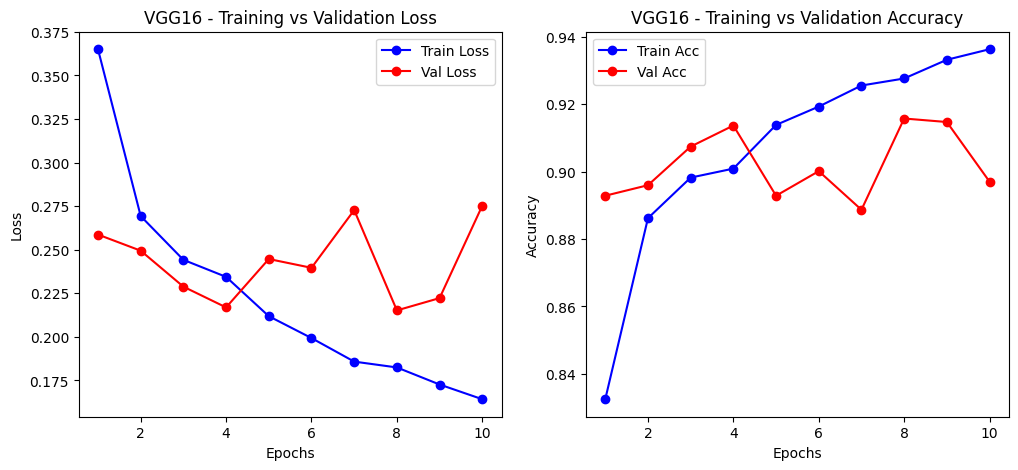

In [5]:
# ======================
# Block 5: Plot Training & Validation Curves
# ======================
def plot_history(history, model_name):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))
    
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'b-o', label="Train Loss")
    plt.plot(epochs, history["val_loss"], 'r-o', label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], 'b-o', label="Train Acc")
    plt.plot(epochs, history["val_acc"], 'r-o', label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Training vs Validation Accuracy")
    plt.legend()

    plt.show()

# Call after training
plot_history(history, model_name)


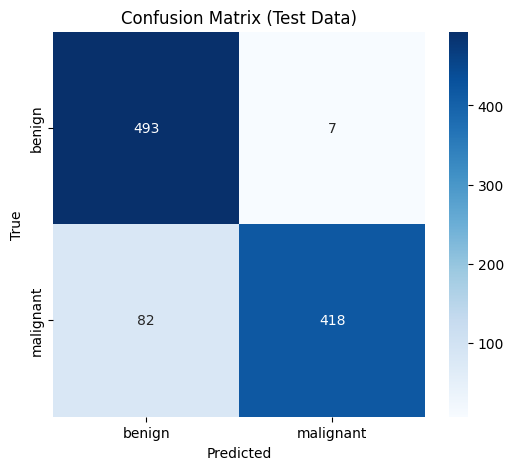


=== Test Metrics ===
Accuracy:  0.9110
Precision: 0.9205
Recall:    0.9110
F1 Score:  0.9105


In [6]:
# ======================
# Block 6: Test Evaluation (Confusion Matrix + Metrics)
# ======================
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Data)")
    plt.show()

    # Metrics
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall    = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1        = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print("\n=== Test Metrics ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return accuracy, precision, recall, f1

# Run evaluation
test_metrics = evaluate_model(model, test_loader, class_names, device)
